In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from pandas import json_normalize
from FCPython import createPitch
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

# Loading the File and Constructing the Dataframe

In [11]:
# Function for finding passes before shot
shot_window = 15
def in_range(pass_time, start, finish):
    return (True in ((start < pass_time) & (pass_time < finish)).unique())

# Size of the pitch in yards
pitchLength = 120
pitchWidth = 80

# Load the competition file
with open('Statsbomb/data/competitions.json') as f:
    competitions = json.load(f)

# World Cup 2018 ID is 43
competition_id = 43

# Load the list of matches for this competition
with open('Statsbomb/data/matches/' + str(competition_id) + '/3.json') as f:
    matches = json.load(f)

# Get all the teams and match IDs
teams = []
match_ids = []

for match in matches:
    if not(match['home_team']['home_team_name'] in teams):
        teams = teams + [match['home_team']['home_team_name']]
    if not(match['away_team']['away_team_name'] in teams):
        teams = teams + [match['away_team']['away_team_name']]

    match_ids = match_ids + [match['match_id']]

# Collect passes and shots from all players
passshot_df = pd.DataFrame(columns=['Team', 'Passes', 'Shots', 'Goals', 'Matches', 'Danger Passes'])
danger_passes_by = dict()
number_of_matches = dict()

for match in matches:
    match_id = match['match_id']
    file_name = str(match_id) + '.json'
    with open('Statsbomb/data/events/' + file_name) as data_file:
        data = json.load(data_file)
    dfall = json_normalize(data, sep = '_').assign(match_id = file_name[:-5])
    
    # Print out the whole fixures
    print(match['home_team']['home_team_name'] + ' vs ' + match['away_team']['away_team_name'])
    
    # Home team
    for theteam in [match['home_team']['home_team_name'],match['away_team']['away_team_name']]:
        team_actions = (dfall['team_name'] == theteam)
        df = dfall[team_actions]
        
        # A dataframe of passes
        passes_match = df.loc[df['type_name'] == 'Pass'].set_index('id')
        
        # A dataframe of shots
        shots_match = df.loc[df['type_name'] == 'Shot'].set_index('id')

        # Find passes within 15 seconds of a shot (shot_window), exclude corners
        shot_times = shots_match['minute'] * 60 + shots_match['second']
        shot_start = shot_times - shot_window
        pass_times = passes_match['minute'] * 60 + passes_match['second']
        pass_to_shot = pass_times.apply(lambda x: in_range(x, shot_start, shot_times))
        iscorner = passes_match['pass_type_name'] == 'Corner'
        danger_passes = passes_match[np.logical_and(pass_to_shot, np.logical_not(iscorner))]
        
        if theteam in danger_passes_by:
            danger_passes_by[theteam] = danger_passes_by[theteam].append(danger_passes)
            number_of_matches[theteam] = number_of_matches[theteam] + 1
        else:
            danger_passes_by[theteam] = danger_passes
            number_of_matches[theteam] = 1
            
        if theteam == match['home_team']['home_team_name']:
            goalsscored = match['home_score']
        else:
            goalsscored = match['away_score']
            
        passshot_df = passshot_df.append({
                    "Team": theteam,
                    "Passes": len(passes_match),
                    "Shots": len(shots_match),
                    "Goals": goalsscored,
                    "Danger Passes": len(danger_passes)
                    },ignore_index=True)       

Croatia vs Denmark
Nigeria vs Iceland
Poland vs Colombia
Croatia vs Nigeria
Brazil vs Costa Rica
Germany vs Mexico
Australia vs Peru
Serbia vs Brazil
Senegal vs Colombia
Panama vs Tunisia
Switzerland vs Costa Rica
France vs Australia
Uruguay vs Russia
Brazil vs Mexico
Russia vs Croatia
Denmark vs Australia
Costa Rica vs Serbia
France vs Peru
Belgium vs Japan
Belgium vs Panama
Argentina vs Croatia
France vs Argentina
Brazil vs Belgium
Uruguay vs France
France vs Croatia
Iceland vs Croatia
Poland vs Senegal
Denmark vs France
Egypt vs Uruguay
Argentina vs Iceland
Spain vs Russia
Belgium vs Tunisia
Peru vs Denmark
Uruguay vs Saudi Arabia
South Korea vs Mexico
Spain vs Morocco
Brazil vs Switzerland
Nigeria vs Argentina
Japan vs Senegal
Saudi Arabia vs Egypt
Uruguay vs Portugal
Japan vs Poland
Morocco vs Iran
Iran vs Spain
Russia vs Saudi Arabia
Sweden vs South Korea
Portugal vs Spain
Portugal vs Morocco
Mexico vs Sweden
Iran vs Portugal
England vs Panama
England vs Belgium
Colombia vs Engla

# Plotting an Ordinary Least Squares Regression Model for Passes vs Shots

                            OLS Regression Results                            
Dep. Variable:                  Shots   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.352
Method:                 Least Squares   F-statistic:                     70.08
Date:                Mon, 19 Jul 2021   Prob (F-statistic):           9.30e-14
Time:                        16:38:55   Log-Likelihood:                -374.69
No. Observations:                 128   AIC:                             753.4
Df Residuals:                     126   BIC:                             759.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0354      1.408      1.446      0.1

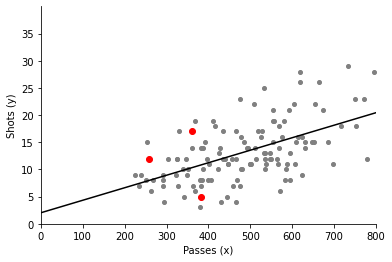

In [25]:
# Plot passes vs. shots
fig,ax = plt.subplots(num=1)
ax.plot('Passes', 'Shots', data=passshot_df, linestyle='none', markersize=4, marker='o', color='grey')
team_of_interest = "South Korea"
team_of_interest_matches = (passshot_df['Team'] == team_of_interest)
ax.plot('Passes', 'Shots', data=passshot_df[team_of_interest_matches], linestyle='none', markersize=6, marker='o', color='red')
ax.set_xticks(np.arange(0, 1000, step=100))
ax.set_yticks(np.arange(0, 40, step=5))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')

# Fit a straight line regression model for how number of passes predict number of shots from number of passes
passshot_df['Shots'] = pd.to_numeric(passshot_df['Shots']) 
passshot_df['Passes'] = pd.to_numeric(passshot_df['Passes']) 
passshot_df['Goals'] = pd.to_numeric(passshot_df['Goals']) 

# Fit the model
model_fit = smf.ols(formula='Shots ~ Passes', data=passshot_df[['Shots','Passes']]).fit()
print(model_fit.summary())        
b = model_fit.params
x = np.arange(0, 1000, step=0.5)
y = b[0] + b[1] * x
ax.plot( x, y, linestyle='-', color='black')
ax.set_ylim(0,40)
ax.set_xlim(0,800) 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.show()

# Showing Poisson Regrassion for Goals

In [26]:
# For goals (and strictly speaking even for shots) it is better to do a Poisson regression
poisson_model = smf.glm(formula="Goals ~ Passes + Team", data=passshot_df, family=sm.families.Poisson()).fit()
print(poisson_model.summary())
b = poisson_model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Goals   No. Observations:                  128
Model:                            GLM   Df Residuals:                       95
Model Family:                 Poisson   Df Model:                           32
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -170.23
Date:                Mon, 19 Jul 2021   Deviance:                       111.91
Time:                        16:40:41   Pearson chi2:                     93.5
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.2704 

# Comparative Pass Maps

Croatia 309
Denmark 102
Nigeria 107
Iceland 74
Poland 80
Colombia 85
Brazil 263
Costa Rica 69
Germany 247
Mexico 138
Australia 49
Peru 115
Serbia 89
Senegal 62
Panama 57
Tunisia 131
Switzerland 130
France 220
Uruguay 128
Russia 106
Belgium 290
Japan 121
Argentina 147
Egypt 94
Spain 246
Saudi Arabia 86
South Korea 77
Morocco 106
Portugal 141
Iran 35
Sweden 132
England 192


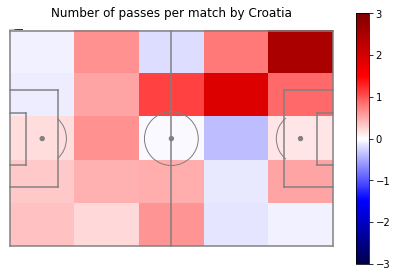

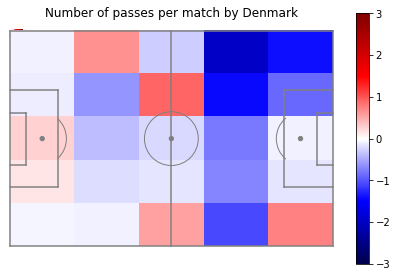

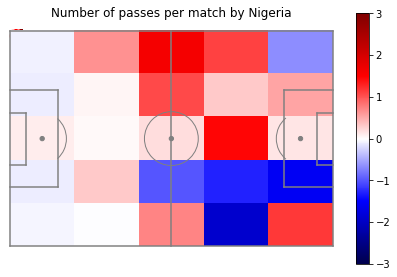

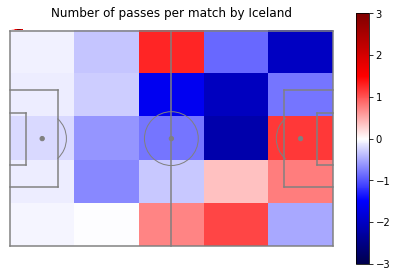

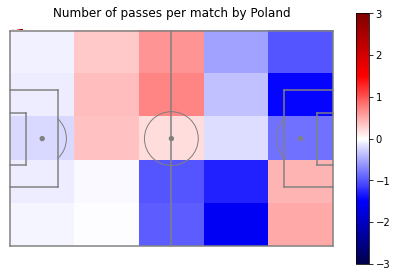

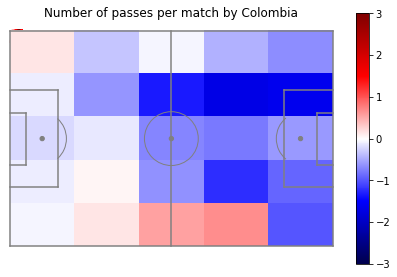

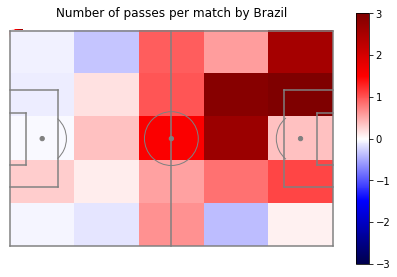

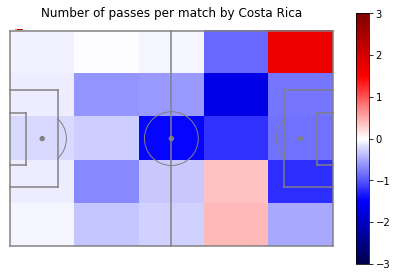

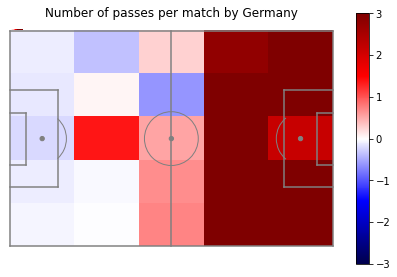

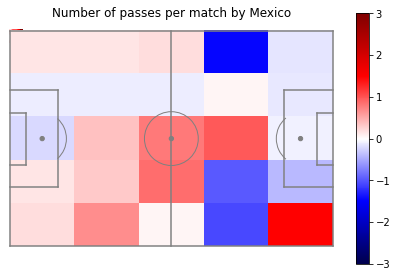

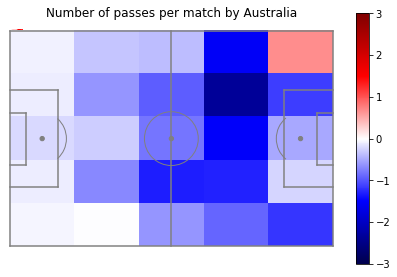

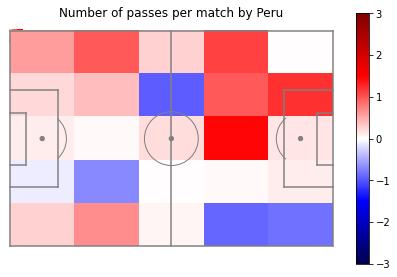

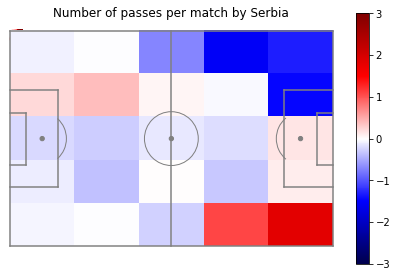

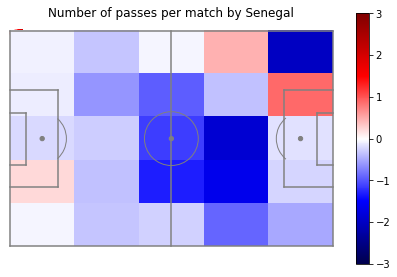

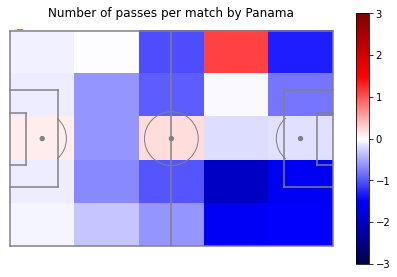

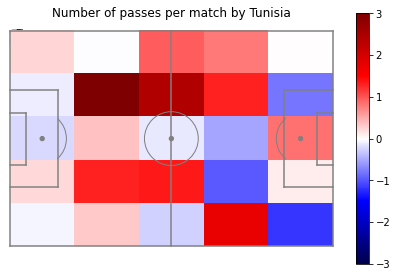

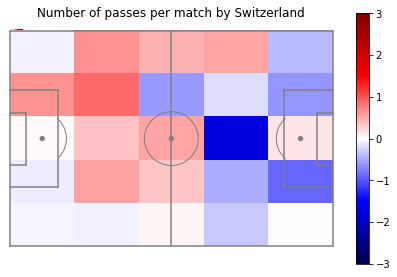

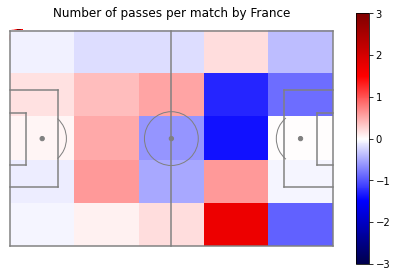

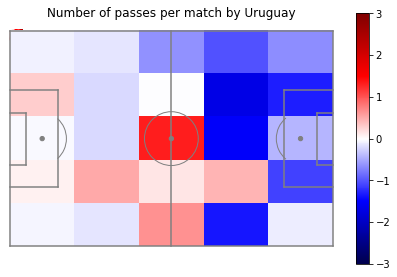

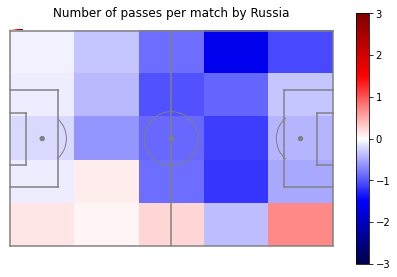

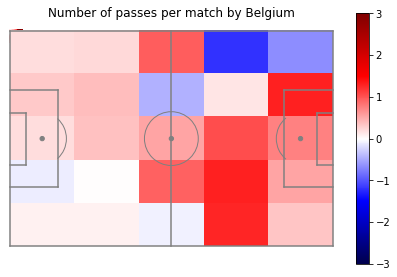

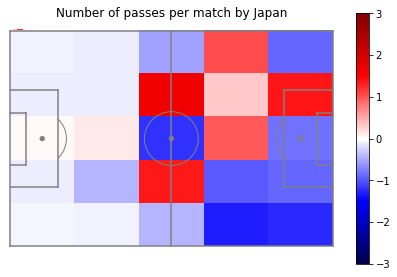

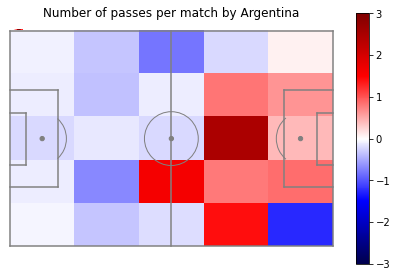

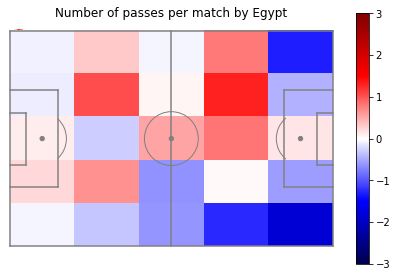

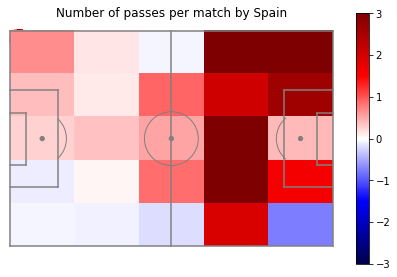

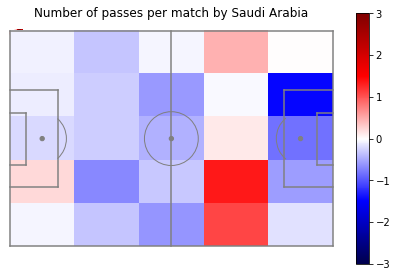

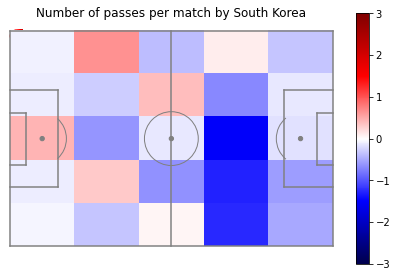

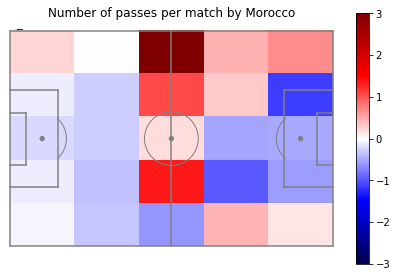

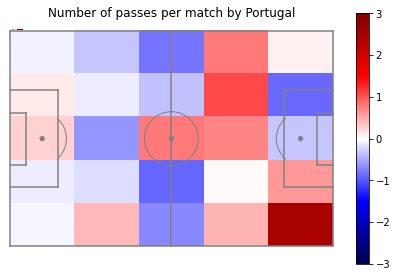

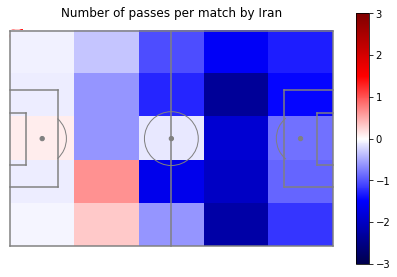

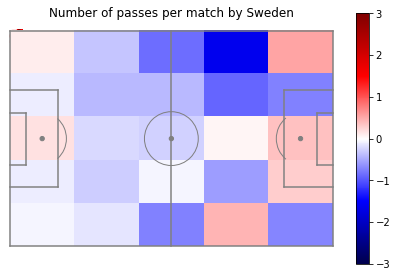

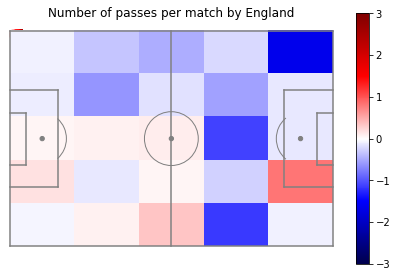

In [10]:
# Make comparative pass maps
x_all = []
y_all = []
H_Pass = dict()
for team in teams:
    dp = danger_passes_by[team]
    print(team + ' ' + str(len(dp)))
    
    x = []
    y = []
    for i, apass in dp.iterrows():
        x.append(apass['location'][0])
        y.append(pitchWidth-apass['location'][1])

    # Make a histogram of passes
    H_Pass[team] = np.histogram2d(y, x, bins=5, range=[[0, pitchWidth], [0, pitchLength]])
    
    x_all = x_all + x
    y_all = y_all + y

H_Pass_All = np.histogram2d(y_all, x_all, bins=5, range=[[0, pitchWidth], [0, pitchLength]])

# Compare to mean
for team in teams:
    (fig, ax) = createPitch(pitchLength, pitchWidth,'yards', 'gray')
    pos = ax.imshow(H_Pass[team][0]/number_of_matches[team], aspect='auto', cmap=plt.cm.seismic, vmin=-3, vmax=3)
    pos = ax.imshow(H_Pass[team][0]/number_of_matches[team] - H_Pass_All[0]/(len(matches)*2), extent=[0,120,0,80], aspect='auto', cmap=plt.cm.seismic, vmin=-3, vmax=3)
    
    ax.set_title('Number of passes per match by ' + team)
    plt.xlim((-1, 121))
    plt.ylim((83, -3))
    plt.tight_layout()
    plt.gca().set_aspect('equal', adjustable='box')
    fig.colorbar(pos, ax=ax)
    plt.show()